In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from torchtext.data.utils import get_tokenizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
# Part 1: Supervised

In [3]:
reviews = pd.read_csv("data/customer_review_text.csv")
reviews.head()


,"Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score"
0,"""I love this product!"", Positive, Twitter, 202..."
1,"""The service was terrible."", Negative, Yelp Re..."
2,"""This movie is amazing!"", Positive, IMDb, 2023..."
3,"""I'm so disappointed with their customer suppo..."
4,"""Just had the best meal of my life!"", Positive..."


This data is extremely messy. While the data is complete, all columns [Text, Sentiment, Source, Date Time, User ID, Location, and Conf. score] are all within the same column. We will use regexp to separate them into different columns.

In [4]:
reviews.iloc[0,0]

'"I love this product!", Positive, Twitter, 2023-06-15 09:23:14, @user123, New York, 0.85'

In [5]:
reviews.shape

(98, 1)

In [6]:
for i in range(5):
    print(reviews.iloc[i,0])

"I love this product!", Positive, Twitter, 2023-06-15 09:23:14, @user123, New York, 0.85
"The service was terrible.", Negative, Yelp Reviews, 2023-06-15 11:45:32, user456, Los Angeles, 0.65
"This movie is amazing!", Positive, IMDb, 2023-06-15 14:10:22, moviefan789, London, 0.92
"I'm so disappointed with their customer support.", Negative, Online Forum, 2023-06-15 17:35:11, forumuser1, Toronto, 0.78
"Just had the best meal of my life!", Positive, TripAdvisor, 2023-06-16 08:50:59, foodie22, Paris, 0.88


First, rename the column for ease of use later in the code.

In [7]:
col = reviews.columns[0]
col

'Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'

In [8]:
df_clean = pd.DataFrame({
   "text": reviews[col].str.extract(r'"([^"]+)"', expand=False),
   "sentiment": reviews[col].str.extract(r'(Positive|Negative)', expand=False),
   "source": reviews[col].str.extract(r'\S+, \S+, (\S+),', expand=False),
   "date": reviews[col].str.extract(r'(\d{4}-\d{2}-\d{2})', expand=False),
   "time": reviews[col].str.extract(r'(\d{2}:\d{2}:\d{2})', expand=False),
   "user": reviews[col].str.extract(r'\d{2}:\d{2}:\d{2}, (\S+)', expand=False),
   "city": reviews[col].str.extract(r'\d{2}:\d{2}:\d{2}, \S+, (.+?), 0\.\d{2}$', expand=False),
   "confidence": reviews[col].str.extract(r'(0\.\d{2}$)', expand=False)
   })

df_clean["dateTime"] = df_clean["date"]+" "+df_clean["time"]


In [9]:
df_clean.head()

,text,sentiment,source,date,time,user,city,confidence,dateTime
0,I love this product!,Positive,Twitter,2023-06-15,09:23:14,"@user123,",New York,0.85,2023-06-15 09:23:14
1,The service was terrible.,Negative,NaN,2023-06-15,11:45:32,"user456,",Los Angeles,0.65,2023-06-15 11:45:32
2,This movie is amazing!,Positive,IMDb,2023-06-15,14:10:22,"moviefan789,",London,0.92,2023-06-15 14:10:22
3,I'm so disappointed with their customer support.,Negative,Toronto,2023-06-15,17:35:11,"forumuser1,",Toronto,0.78,2023-06-15 17:35:11
4,Just had the best meal of my life!,Positive,TripAdvisor,2023-06-16,08:50:59,"foodie22,",Paris,0.88,2023-06-16 08:50:59


In [10]:
df_clean.dtypes

text          object
sentiment     object
source        object
date          object
time          object
user          object
city          object
confidence    object
dateTime      object
dtype: object

### Changing DataTypes

In [11]:
df_clean["sentiment"].value_counts()

sentiment
Positive    53
Negative    43
Name: count, dtype: int64

In [12]:
reviews_df = df_clean.copy()
reviews_df["sentiment"] = np.where(reviews_df["sentiment"] == "Positive", 1, np.where(reviews_df["sentiment"] == "Negative", 0, np.nan))
reviews_df

,text,sentiment,source,date,time,user,city,confidence,dateTime
0,I love this product!,1.0,Twitter,2023-06-15,09:23:14,"@user123,",New York,0.85,2023-06-15 09:23:14
1,The service was terrible.,0.0,NaN,2023-06-15,11:45:32,"user456,",Los Angeles,0.65,2023-06-15 11:45:32
2,This movie is amazing!,1.0,IMDb,2023-06-15,14:10:22,"moviefan789,",London,0.92,2023-06-15 14:10:22
3,I'm so disappointed with their customer support.,0.0,Toronto,2023-06-15,17:35:11,"forumuser1,",Toronto,0.78,2023-06-15 17:35:11
4,Just had the best meal of my life!,1.0,TripAdvisor,2023-06-16,08:50:59,"foodie22,",Paris,0.88,2023-06-16 08:50:59
...,...,...,...,...,...,...,...,...,...
93,I can't stop listening to this song. It's my n...,1.0,Spotify,2023-07-03,09:17:52,"musiclover789,",Berlin,0.91,2023-07-03 09:17:52
94,Their website is so confusing and poorly desig...,0.0,Toronto,2023-07-03,11:59:18,"user789,",Toronto,0.68,2023-07-03 11:59:18
95,I had an incredible experience at the theme pa...,1.0,Orlando,2023-07-03,14:40:05,"thrillseeker1,",Orlando,0.89,2023-07-03 14:40:05
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#changing datatypes
from datetime import datetime
categories = {"text":"string",
              "sentiment":"category",
              "source":"category",
              "date": "datetime64[ns]",
              "time":"string",
              "dateTime":"datetime64[ns]",
              "user":"category",
              "city":"category",
              "confidence":"float"}


reviews_clean = reviews_df.astype(categories)
reviews_clean.head()


,text,sentiment,source,date,time,user,city,confidence,dateTime
0,I love this product!,1.0,Twitter,2023-06-15,09:23:14,"@user123,",New York,0.85,2023-06-15 09:23:14
1,The service was terrible.,0.0,NaN,2023-06-15,11:45:32,"user456,",Los Angeles,0.65,2023-06-15 11:45:32
2,This movie is amazing!,1.0,IMDb,2023-06-15,14:10:22,"moviefan789,",London,0.92,2023-06-15 14:10:22
3,I'm so disappointed with their customer support.,0.0,Toronto,2023-06-15,17:35:11,"forumuser1,",Toronto,0.78,2023-06-15 17:35:11
4,Just had the best meal of my life!,1.0,TripAdvisor,2023-06-16,08:50:59,"foodie22,",Paris,0.88,2023-06-16 08:50:59


In [14]:
reviews_clean.dtypes

text          string[python]
sentiment           category
source              category
date          datetime64[ns]
time          string[python]
user                category
city                category
confidence           float64
dateTime      datetime64[ns]
dtype: object

Axes(0.125,0.11;0.698618x0.77)
text           2
sentiment      2
source        21
date           2
time           2
user           2
city           2
confidence     2
dateTime       2
dtype: int64


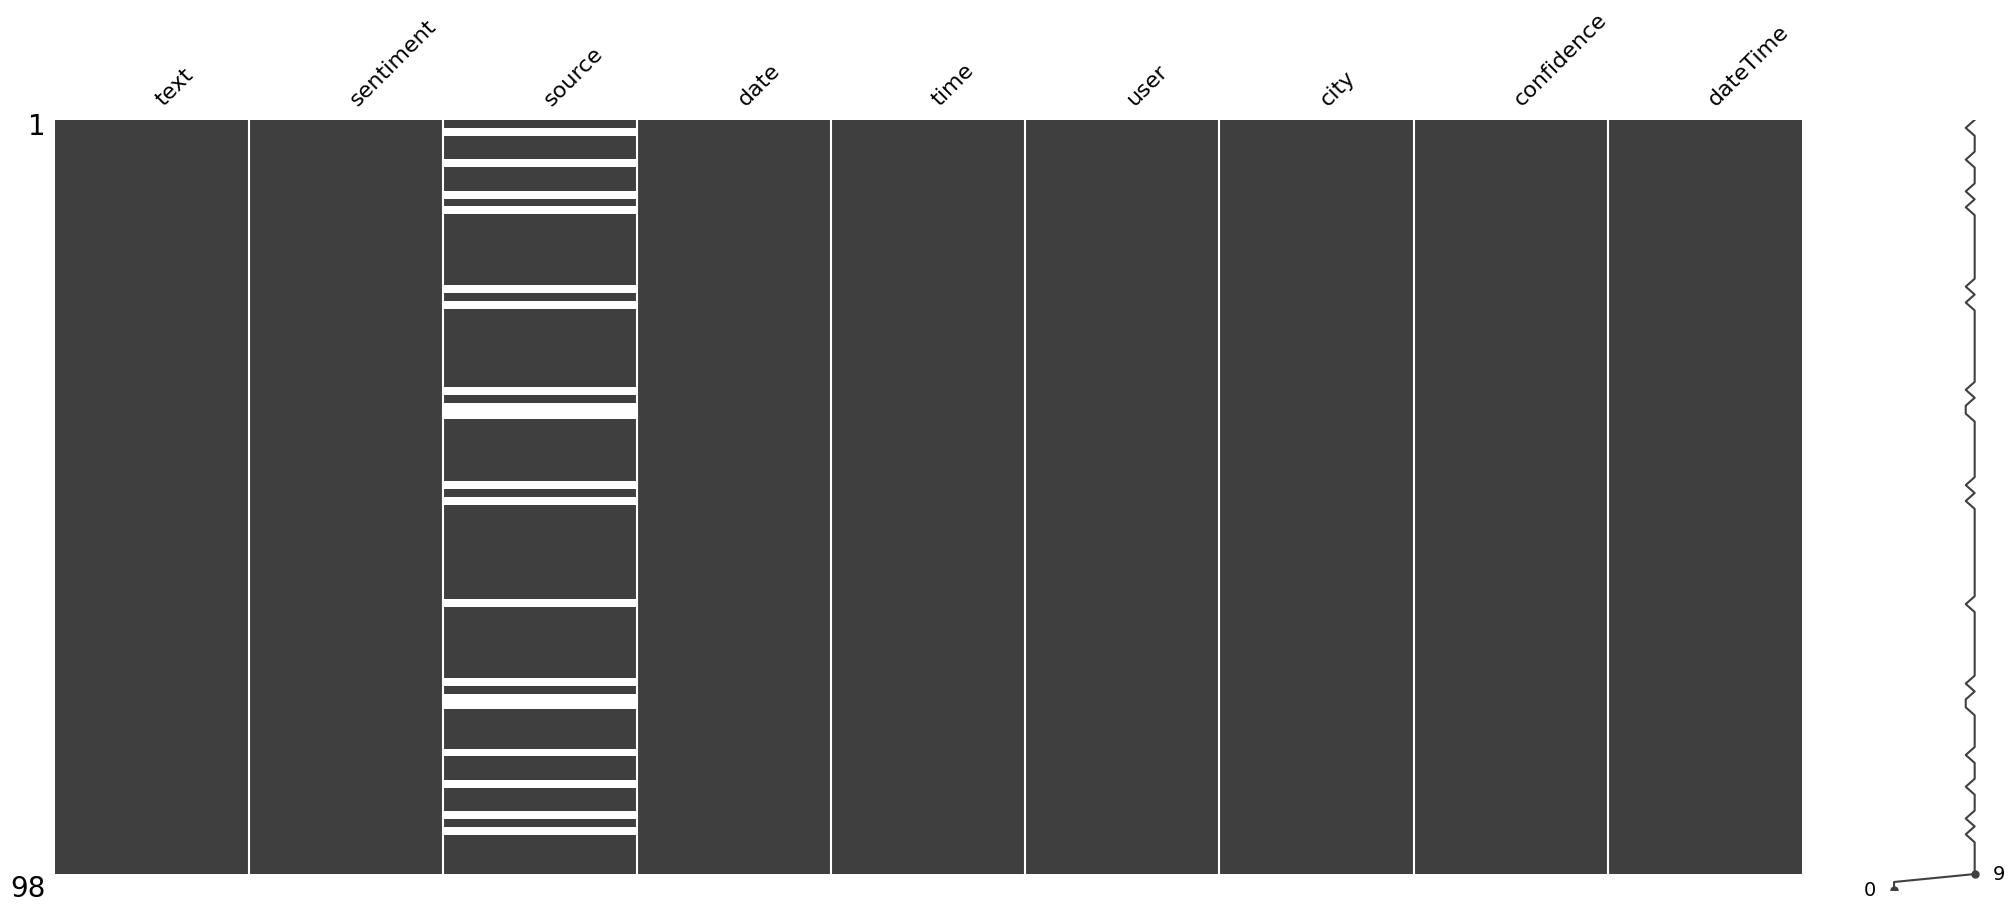

In [15]:
import missingno as msno 

print(msno.matrix(reviews_clean))
print(reviews_clean.isna().sum())



Looking at the amount of missing per column, their locations, and specifically the amount in source, we'll use .dropna() subsetted for all other cols

In [16]:
# Assuming 'reviews_clean' is your DataFrame
reviews_clean.dropna(subset=reviews_clean.columns.difference(['source']), inplace= True)
print(reviews_clean.isna().sum(),
reviews_clean.shape)


text           0
sentiment      0
source        19
date           0
time           0
user           0
city           0
confidence     0
dateTime       0
dtype: int64 (96, 9)


In [17]:
reviews = reviews_clean[["text","sentiment"]].values.tolist()
reviews[:10]

[['I love this product!', 1.0],
 ['The service was terrible.', 0.0],
 ['This movie is amazing!', 1.0],
 ["I'm so disappointed with their customer support.", 0.0],
 ['Just had the best meal of my life!', 1.0],
 ['The quality of this product is subpar.', 0.0],
 ["I can't stop listening to this song. It's incredible!", 1.0],
 ['Their website is so user-friendly. Love it!', 1.0],
 ['I loved the movie! It was fantastic!', 1.0],
 ['The customer service was terrible.', 0.0]]

Modelling using CNN and a fully connected linear layer. Starting with embedding.

In [18]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/scottpitcher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Define your Dataset class
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words("english"))

tokenizer = get_tokenizer("basic_english")
stemmer = PorterStemmer() 

class CustomerReview(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx][0], self.data[idx][1]


def preprocess_sentences(sentences):
    processed_sentences = []
    for sentence,label in sentences:
        sentence = sentence.lower()
        tokens = tokenizer(sentence)
        tokens = [token for token in tokens if token not in stop_words]
        tokens = [stemmer.stem(token) for token in tokens]
        processed_sentences.append(' '.join(tokens))
    return processed_sentences

# Complete the encoding function
def encode_sentences(sentences):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(sentences)
    return X.toarray(), vectorizer
    
# Complete the text processing pipeline
def text_processing_pipeline(sentences):
    processed_sentences = preprocess_sentences(sentences)
    encoded_sentences, vectorizer = encode_sentences(processed_sentences)
    dataset = CustomerReview(encoded_sentences)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    return dataloader, vectorizer

### Creating a CNN Network for the reviews

In [26]:
reviews_dict = dict(reviews)
X_train, X_test, y_train, y_test = train_test_split(list(reviews_dict.keys()), list(reviews_dict.values()), test_size=0.3, random_state=123)


In [27]:
train_data = zip(X_train, y_train)
test_data = zip(X_test, y_test)

train_dataloader, train_vectorizer = text_processing_pipeline(train_data)
test_dataloader, test_vectorizer = text_processing_pipeline(test_data)


In [23]:
print(len(y_test))

23


In [28]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


class TextClassificationCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(TextClassificationCNN, self).__init__()
        # Initialize the embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(1, embed_dim, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(embed_dim, 2)

    def forward(self, text):
        text = text.unsqueeze(1)
        embedded = self.embedding(text)#.permute(0, 2, 1)
        # Pass the embedded text through the convolutional layer and apply a ReLU
        conved = F.relu(self.conv(embedded))
        conved = conved.mean(dim=2)
        return self.fc(conved)
    
    def reset_parameters(self):

        for param in self.parameters():
            if param.requires_grad:
                param.data.uniform_(-0.1, 0.1)  




In [48]:
import torch.optim as optim  
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
model = TextClassificationCNN(vocab_size=len(train_vectorizer.get_feature_names_out()),embed_dim=50)
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 1

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_dataloader:
        labels = torch.clamp(labels, 0, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()



In [49]:
# Testing loop
model.eval()
correct_predictions = 0
total_samples = len(X_test)
accuracy = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == labels.squeeze()).sum().item()

accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 95.65%


In [79]:
def review_training(epoch, X,y):
    for epoch in range(epoch):
        for sentence, label in zip(X, y):     
            # Clear the gradients
            model.zero_grad()
            word_to_ix = {word: idx for idx, word in enumerate(sentence.split())}
            sentence = torch.LongTensor([word_to_ix.get(w, 0) for w in sentence]).unsqueeze(0) 
            label = torch.LongTensor([int(label)])
            outputs = model(sentence)
            loss = criterion(outputs, label)
            loss.backward()
            # Update the parameters
            optimizer.step()

def review_testing(X,y):
    correct_predictions = 0

    for test_review, test_label in zip(X,y):
        word_to_ix = {word: idx for idx, word in enumerate(test_review.split())}
        input_tensor = torch.LongTensor([word_to_ix.get(w, 0) for w in test_review]).unsqueeze(0)
        outputs = model(input_tensor)
        _, predicted_class = torch.max(outputs, 1)
        correct_predictions += (predicted_class == test_label).item()

    accuracy = correct_predictions / len(X)
    return accuracy

In [81]:
accuracy_dict = {}
for i in range(36):
    model.train()
    review_training(epoch = i, X=X_train, y=y_train)
    model.eval()
    accuracy = review_testing(X_test, y_test)
    accuracy_dict[i] = accuracy


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

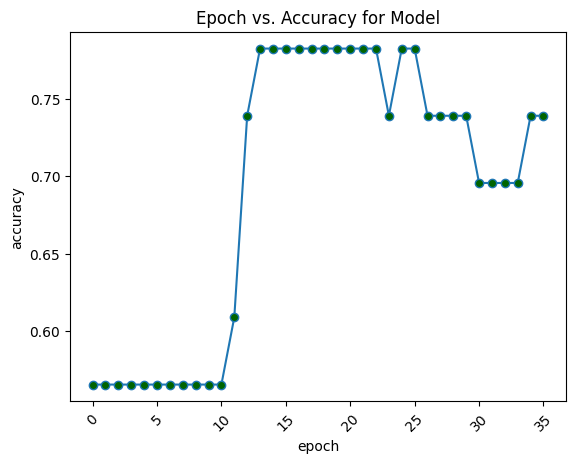

In [57]:
import matplotlib.pyplot as plt
plt.plot(accuracy_dict.keys(),accuracy_dict.values(), marker = 'o',markerfacecolor = 'darkgreen')
plt.xlabel("epoch")
plt.xticks(rotation = 45)
plt.ylabel('accuracy')
plt.title("Epoch vs. Accuracy for Model")
plt.show()


In [60]:
max_epoch = max(accuracy_dict, key=lambda k: accuracy_dict[k])
max_accuracy = accuracy_dict[max_epoch]

print(f"Maximum accuracy ({max_accuracy * 100:.2f}%) achieved at epoch {max_epoch + 1}")


Maximum accuracy (78.26%) achieved at epoch 9


In [ ]:
#Part 2: Unsupervised (In Progress)

In [59]:
data = pd.read_csv("data/reddit_vm.csv")
data.head(10)

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28
5,Canada: Oxford-AstraZeneca vaccine approval ex...,5,lftbji,https://www.canadaforums.ca/2021/02/canada-oxf...,0,1.612869e+09,NaN,2021-02-09 13:17:11
6,Comment,1,ej9x066,NaN,0,1.553474e+09,Your OP. It's not a myth. Only one vaccine con...,2019-03-25 02:34:53
7,Fuck you anti-vaxxing retards,10,g6jkhp,https://www.reddit.com/r/VaccineMyths/comments...,8,1.587663e+09,https://youtu.be/zBkVCpbNnkU,2020-04-23 20:23:42
8,Comment,0,fofa0yy,NaN,0,1.587760e+09,Because Anti-Vaxxers have no sense,2020-04-24 23:19:50
9,Comment,0,ej9xuaf,NaN,0,1.553475e+09,"What do you mean by ""your OP"". I am fairly new...",2019-03-25 02:45:21


In [60]:
data.head(1).body

0    NaN
Name: body, dtype: object

In [61]:
data_full = data.dropna(subset = ["body"])
data_full

,title,score,id,url,comms_num,created,body,timestamp
6,Comment,1,ej9x066,NaN,0,1.553474e+09,Your OP. It's not a myth. Only one vaccine con...,2019-03-25 02:34:53
7,Fuck you anti-vaxxing retards,10,g6jkhp,https://www.reddit.com/r/VaccineMyths/comments...,8,1.587663e+09,https://youtu.be/zBkVCpbNnkU,2020-04-23 20:23:42
8,Comment,0,fofa0yy,NaN,0,1.587760e+09,Because Anti-Vaxxers have no sense,2020-04-24 23:19:50
9,Comment,0,ej9xuaf,NaN,0,1.553475e+09,"What do you mean by ""your OP"". I am fairly new...",2019-03-25 02:45:21
10,Comment,1,ej9x2qr,NaN,0,1.553474e+09,"When they say there's no thimerasol, they mean...",2019-03-25 02:35:47
...,...,...,...,...,...,...,...,...
1597,Comment,2,elrv9ua,NaN,0,1.556223e+09,Lol. My comprehension is comprehensive.\r\nYou...,2019-04-25 23:11:10
1598,Comment,1,elrud7d,NaN,0,1.556223e+09,"If you have trouble finding it, that's one thi...",2019-04-25 23:02:04
1599,Comment,0,elrtjl5,NaN,0,1.556222e+09,Is there music playing where you are because y...,2019-04-25 22:53:50
1600,Comment,1,elrrt5l,NaN,0,1.556221e+09,How long does it take ethyl mercury to metabol...,2019-04-25 22:35:39


In [62]:
descriptions = data_full.body.to_list()
descriptions[:5]

["Your OP. It's not a myth. Only one vaccine contains it and you can get it without it. So your OP is pointless flex. ",
 'https://youtu.be/zBkVCpbNnkU',
 'Because Anti-Vaxxers have no sense',
 'What do you mean by "your OP". I am fairly new to reddit.',
 "When they say there's no thimerasol, they mean in the childhood schedule. That IS a fact. "]

### Looking at word frequencies

In [63]:
threshold = 1000
desc_joined = ''.join(descriptions)
tokens = tokenizer(desc_joined)

freq_dist = FreqDist(tokens)
freq_dist
common_tokens = [token for token in tokens if freq_dist[token] > threshold]
print(common_tokens[:5])

['.', 'it', "'", 'a', '.']


Error with stopword importing, this code fixed it